In [2]:
# !pip install opendatasets plotly --quiet
import opendatasets as od
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import plotly.express as px
import jovian

<IPython.core.display.Javascript object>

In [3]:
# Read the train.csv file
train_df = pd.read_csv('./ashrae-energy-prediction/train.csv',parse_dates=['timestamp'])

# # # Read the building_metadata.csv file
# building_df = pd.read_csv('./ashrae-energy-prediction/building_metadata.csv')


weather_train_df= pd.read_csv('./ashrae-energy-prediction/weather_train.csv',parse_dates=['timestamp'])

meta_df = pd.read_csv('./ashrae-energy-prediction/building_metadata.csv',parse_dates=['year_built'])

**DATA DESCRIPTION**

**CONVERT TIMESTAMP AS DATETIME FORMAT**


In [4]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
meta_df['year_built'] = pd.to_datetime(meta_df['year_built'])


In [59]:
train_df.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


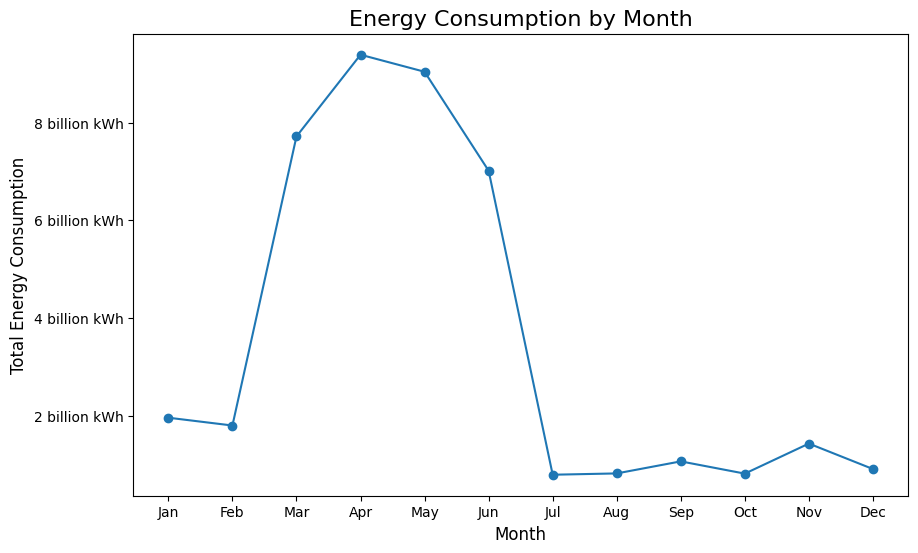

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Extract the month from the timestamp
train_df['month'] = train_df['timestamp'].dt.month

# Group the data by month and calculate the total energy consumption
monthly_energy = train_df.groupby('month')['meter_reading'].sum()

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_energy.index, monthly_energy, marker='o')

# Set x and y labels and add a title
plt.xlabel('Month')
plt.ylabel('Total Energy Consumption')
plt.title('Energy Consumption in 2016')

# Set the x-axis tick labels as month names
month_names = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS').strftime('%b')
plt.xticks(monthly_energy.index, month_names)

# Format the y-axis labels as billion kWh or million kWh
def energy_formatter(x, pos):
    if x >= 1e9:
        return f'{x / 1e9:.0f} billion kWh'
    elif x >= 1e6:
        return f'{x / 1e6:.0f} million kWh'
    else:
        return f'{x / 1e3:.0f} thousand kWh'

formatter = FuncFormatter(energy_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()


In [22]:
weather_train_df.sample(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
58533,6,2016-09-02 06:00:00,20.6,2.0,17.2,0.0,1015.9,360.0,1.5
104664,11,2016-12-17 04:00:00,-17.9,NaN,-20.2,NaN,1023.7,80.0,2.6
103150,11,2016-10-14 08:00:00,0.0,NaN,-1.3,NaN,1027.2,210.0,0.5
130575,14,2016-12-01 00:00:00,12.2,NaN,11.1,5.0,1005.6,50.0,3.1
38529,4,2016-05-22 12:00:00,13.3,NaN,8.9,0.0,1018.7,260.0,3.6


CONVERT DATATYPES

In [5]:
train_df=train_df.astype({'building_id':'int16','meter':'int8','meter_reading':'float32'})


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


In [6]:
weather_train_df=weather_train_df.astype({'site_id':'int8','air_temperature':'float16',
                       'cloud_coverage':'float16','dew_temperature':'float16',
                       'precip_depth_1_hr':'float16','sea_level_pressure':'float16'
                       ,'wind_speed':'float16','wind_direction':'float16'
                       })

In [33]:
weather_train_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [12]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float16       
 3   cloud_coverage      70600 non-null   float16       
 4   dew_temperature     139660 non-null  float16       
 5   precip_depth_1_hr   89484 non-null   float16       
 6   sea_level_pressure  129155 non-null  float16       
 7   wind_direction      133505 non-null  float16       
 8   wind_speed          139469 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB


In [ ]:
#lets create a hourly based 
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_34588\2007883584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


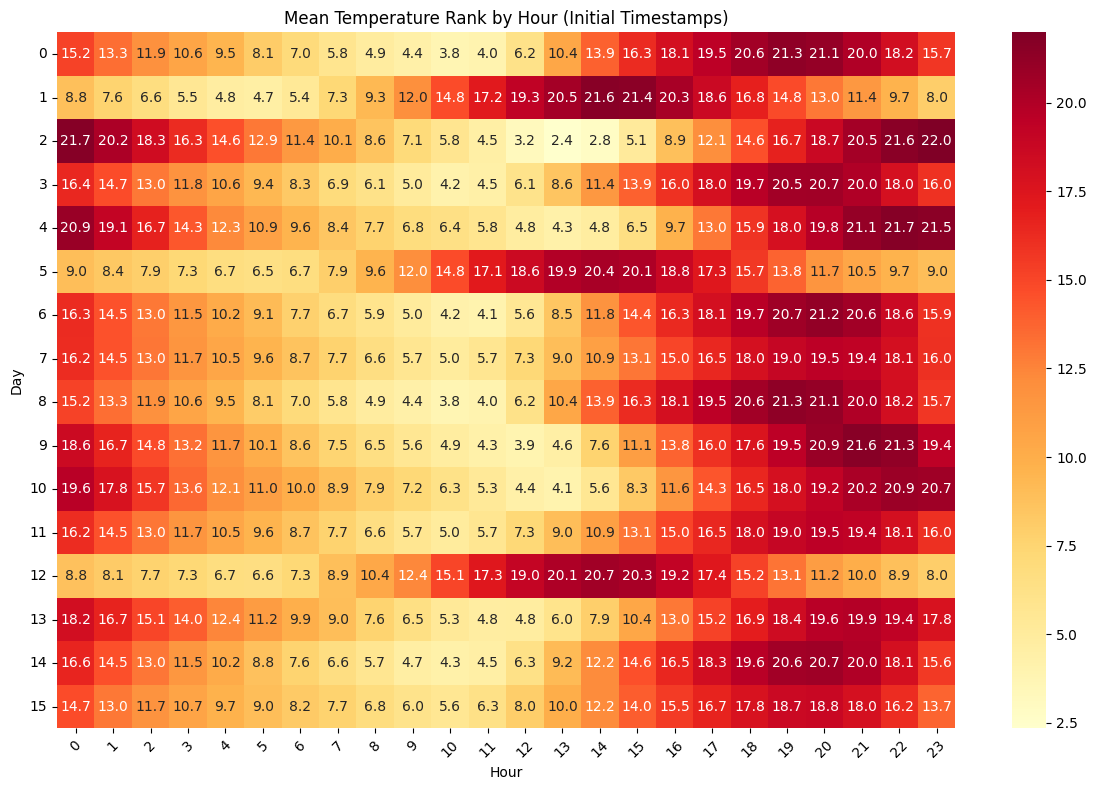

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_2d, cmap='YlOrRd', annot=True, fmt=".1f", cbar=True)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Mean Temperature Rank by Hour (Initial Timestamps)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
def time_alignment(df):
    temp_df=df[['site_id','timestamp','air_temperature']]
    
    # calculate ranks of hourly temperatures within date/site_id chunks
    temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
    
    # create 2D dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
    df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)
    
    # align scale, so each value within row is in [0,1] range
    df_2d = df_2d / df_2d.max(axis=1).values.reshape((-1,1))
    
    # sort by 'closeness' of hour with the highest temperature
    site_ids_argmax_maxtemp=pd.Series(np.argmax(df_2d.values,axis=1)).sort_values().index
    
    # assuming (1,5,12) tuple has the most correct temp peaks at 14:00
    site_ids_offsets= pd.Series(df_2d.values.argmax(axis=1) - 14)
    
    # align rows so that site_id's with similar temperature hour's peaks are near each other
    df_2d=df_2d.iloc[site_ids_argmax_maxtemp]
    temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)
    
    # add offset
    temp_df['timestamp_aligned'] = (temp_df.timestamp - pd.to_timedelta(temp_df.offset, unit='H'))
    
    # replace the timestamp with aligned timestamps in the original dataframe
    df['timestamp']=temp_df['timestamp_aligned']
    return df 

In [8]:
time_alignment(weather_train_df) 

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_23344\1356821763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_23344\1356821763.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)
C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_23344\1356821763.py:24: Setting

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2015-12-31 19:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2015-12-31 20:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2015-12-31 21:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2015-12-31 22:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 13:00:00,3.000000,NaN,-8.000000,NaN,NaN,180.0,5.699219
139769,15,2016-12-31 14:00:00,2.800781,2.0,-8.898438,NaN,1007.5,180.0,7.699219
139770,15,2016-12-31 15:00:00,2.800781,NaN,-7.199219,NaN,1007.5,180.0,5.101562
139771,15,2016-12-31 16:00:00,2.199219,NaN,-6.699219,NaN,1008.0,170.0,4.601562


In [ ]:
#lets create a hourly based 
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_31544\2007883584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


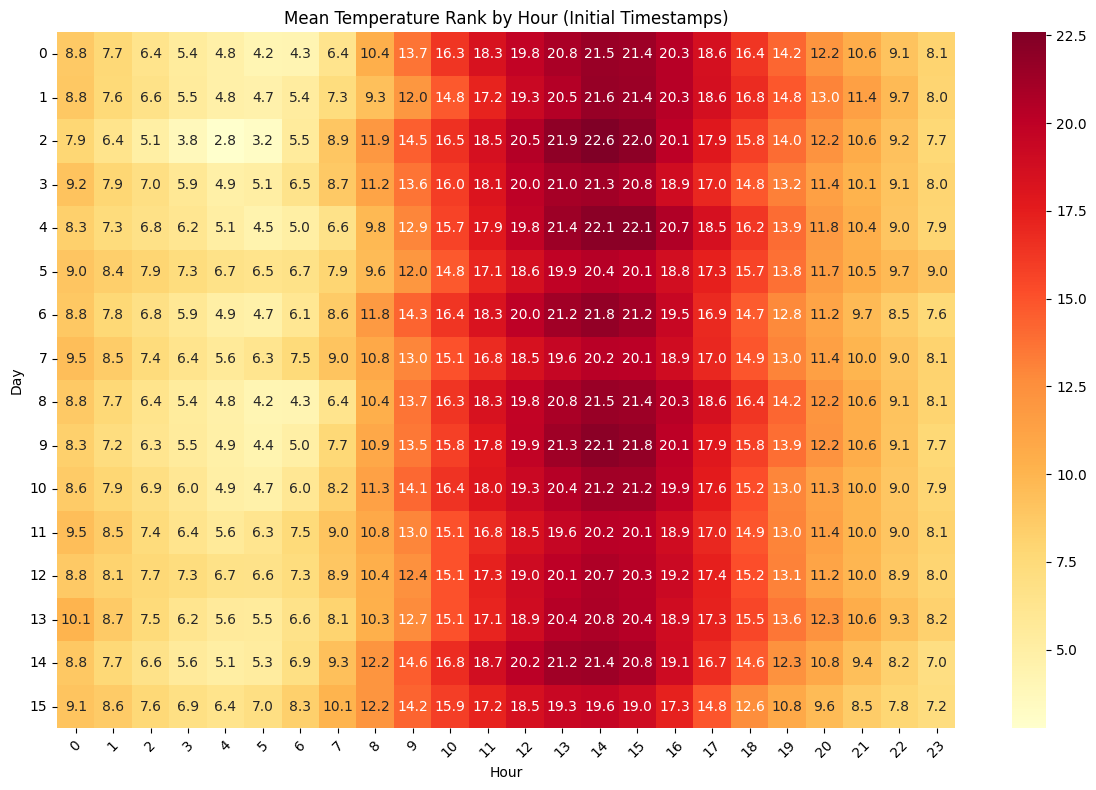

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df_2d, cmap='YlOrRd', annot=True, fmt=".1f", cbar=True)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Mean Temperature Rank by Hour (Initial Timestamps)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
meta_df=meta_df.astype({'site_id':'int8','building_id':'int16',
                       'square_feet':'int16'
                       })

In [37]:
meta_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [19]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   site_id      1449 non-null   int8          
 1   building_id  1449 non-null   int16         
 2   primary_use  1449 non-null   object        
 3   square_feet  1449 non-null   int16         
 4   year_built   675 non-null    datetime64[ns]
 5   floor_count  355 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int16(2), int8(1), object(1)
memory usage: 41.2+ KB


**LETS SEE HOW MANY BUILDINGS ARE THERE IN EACH SITE**

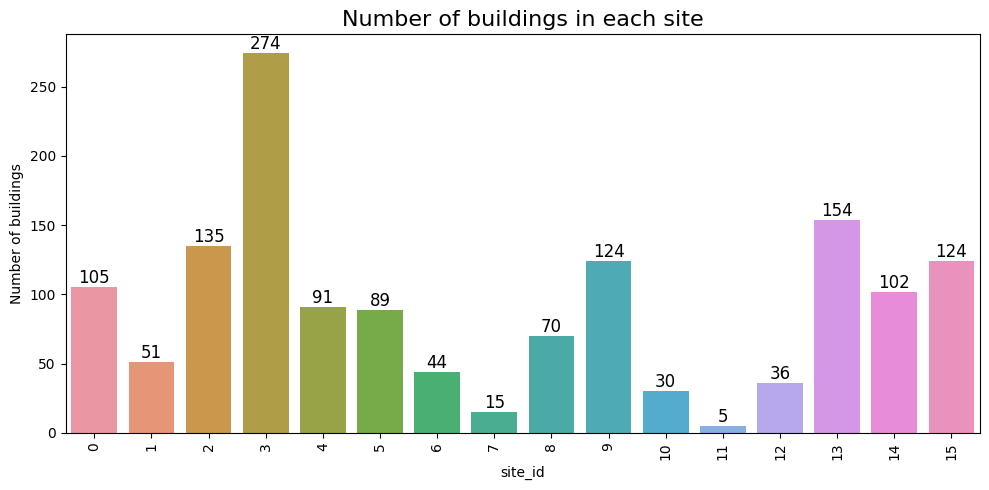

In [ ]:
import seaborn as sns

# Set up subplot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Use countplot to visualize the number of buildings in each site
sns.countplot(data=meta_df, x='site_id', ax=ax)

# Annotate each bar with the number of buildings in that site
for p in ax.patches:
    height = int(p.get_height())  # Convert the count to an integer
    ax.annotate(height, (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=12)

# Set x and y labels and add a title
ax.set_xlabel('site_id')
ax.set_ylabel('Number of buildings')
ax.set_title('Number of buildings in each site', fontsize=16)

# Adjust the x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_31544\141794425.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator



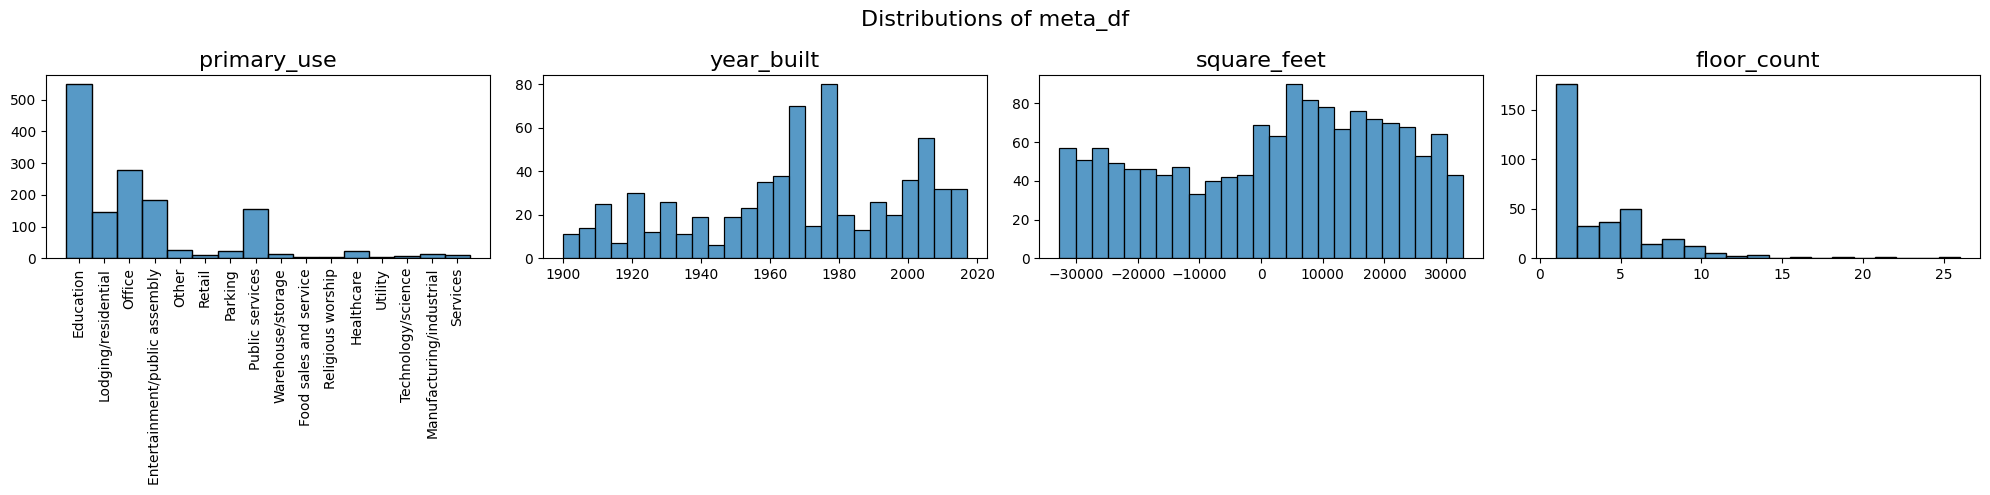

In [42]:
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot the distributions for each feature
for i, col in enumerate(['primary_use', 'year_built', 'square_feet', 'floor_count']):
    if col == 'primary_use':
        sns.histplot(data=meta_df, x=col, ax=axes[i], bins=min(25, len(meta_df[col].unique())))
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    else:
        sns.histplot(data=meta_df, x=col, ax=axes[i], bins=min(25, len(meta_df[col].unique())))
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Set the overall title
fig.suptitle('Distributions of meta_df', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [88]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   site_id      1449 non-null   int8          
 1   building_id  1449 non-null   int16         
 2   primary_use  1449 non-null   object        
 3   square_feet  1449 non-null   int16         
 4   year_built   675 non-null    datetime64[ns]
 5   floor_count  355 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int16(2), int8(1), object(1)
memory usage: 41.2+ KB


**CREATING A SINGLE DF**

In [10]:
merged_df = train_df.merge(meta_df, on='building_id', how='left')
# df = pd.merge(merged_df, weather_train_df, on=['site_id', 'timestamp'], how='left')
df= merged_df.merge(weather_train_df,on=['site_id','timestamp'],how='left')

In [11]:
df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [12]:
df.head(3)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008-01-01,NaN,19.40625,NaN,19.40625,0.0,NaN,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004-01-01,NaN,19.40625,NaN,19.40625,0.0,NaN,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991-01-01,NaN,19.40625,NaN,19.40625,0.0,NaN,0.0,0.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   building_id      int16         
 1   meter            category      
 2   timestamp        datetime64[ns]
 3   meter_reading    float32       
 4   site_id          int8          
 5   primary_use      category      
 6   square_feet      int16         
 7   year_built       datetime64[ns]
 8   air_temperature  float16       
 9   cloud_coverage   float16       
 10  dew_temperature  float16       
 11  wind_direction   float16       
 12  wind_speed       float16       
dtypes: category(2), datetime64[ns](2), float16(5), float32(1), int16(2), int8(1)
memory usage: 713.3 MB


In [11]:
del merged_df,train_df,meta_df

**TAKING CARE OF MISSING VALUES**

In [15]:
df.isna().sum()*100/len(df)

building_id        0.000000
meter              0.000000
timestamp          0.000000
meter_reading      0.000000
site_id            0.000000
primary_use        0.000000
square_feet        0.000000
year_built         0.000000
air_temperature    0.542231
cloud_coverage     0.000000
dew_temperature    0.559455
wind_direction     7.229614
wind_speed         0.774551
dtype: float64

In [11]:
median_year = df['year_built'].median() #filling the year missing values with the median value
df['year_built'].fillna(median_year, inplace=True)
df['cloud_coverage'].fillna(-1, inplace=True)#replacing the missing values in cloud_coverage with -1, here -1 will be considered as missing values where 0-9 is the different oktas value
# Convert object columns to categorical
df['meter'] = df['meter'].astype('category')
df['primary_use'] = df['primary_use'].astype('category')

In [59]:
df.reset_index(drop=True, inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   building_id      int16         
 1   meter            object        
 2   timestamp        datetime64[ns]
 3   meter_reading    float32       
 4   site_id          int8          
 5   primary_use      object        
 6   square_feet      int16         
 7   year_built       datetime64[ns]
 8   air_temperature  float16       
 9   cloud_coverage   float16       
 10  dew_temperature  float16       
 11  wind_direction   float16       
 12  wind_speed       float16       
dtypes: datetime64[ns](2), float16(5), float32(1), int16(2), int8(1), object(2)
memory usage: 983.3+ MB


In [54]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
722,565,0,2016-01-01,7.250000,4,Education,15326,1954-01-01,4.398438,0.0,-2.199219,0.0,1021.0,0.0,0.0
723,566,0,2016-01-01,0.519000,4,Education,2010,1957-01-01,4.398438,0.0,-2.199219,0.0,1021.0,0.0,0.0
724,569,0,2016-01-01,246.000000,4,Education,20555,1964-01-01,4.398438,0.0,-2.199219,0.0,1021.0,0.0,0.0
725,570,0,2016-01-01,79.487999,4,Education,-3406,1964-01-01,4.398438,0.0,-2.199219,0.0,1021.0,0.0,0.0
726,571,0,2016-01-01,17.000000,4,Education,-17582,1980-01-01,4.398438,0.0,-2.199219,0.0,1021.0,0.0,0.0


**DATA DESCRIPTION**

train.csv
- building_id - Foreign key for the building metadata.
- meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- timestamp - When the measurement was taken
- meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

building_meta.csv
- site_id - Foreign key for the weather files.
- building_id - Foreign key for training.csv
- primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- square_feet - Gross floor area of the building
- year_built - Year building was opened
- floor_count - Number of floors of the building

weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

- site_id
- air_temperature - Degrees Celsius
- cloud_coverage - Portion of the sky covered in clouds, in oktas
- dew_temperature - Degrees Celsius
- precip_depth_1_hr - Millimeters
- sea_level_pressure - Millibar/hectopascals
- wind_direction - Compass direction (0-360)
- wind_speed - Meters per second

**LETS MAP METER ID CODE AS PER THE DESCRIPTION**

In [15]:
meter_labels = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
df['meter'] = df['meter'].map(meter_labels)

**REMOVING COLUMNS TO REDUCE THE MEMORY USAGE**

In [13]:
# Drop unnecessary columns
df.drop(['floor_count', 'precip_depth_1_hr', 'sea_level_pressure'], axis=1, inplace=True)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   building_id      int16         
 1   meter            float64       
 2   timestamp        datetime64[ns]
 3   meter_reading    float32       
 4   site_id          int8          
 5   primary_use      category      
 6   square_feet      int16         
 7   year_built       datetime64[ns]
 8   air_temperature  float16       
 9   cloud_coverage   float16       
 10  dew_temperature  float16       
 11  wind_direction   float16       
 12  wind_speed       float16       
dtypes: category(1), datetime64[ns](2), float16(5), float32(1), float64(1), int16(2), int8(1)
memory usage: 848.3 MB


In [19]:
df.sample(3)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,wind_direction,wind_speed
4436418,1195,electricity,2016-03-25 10:00:00,19.004999,13,Office,16472,1969-01-01,6.101562,-1.0,-7.800781,200.0,4.601562
9427936,973,electricity,2016-06-22 15:00:00,225.000000,9,Office,-2648,1969-01-01,34.406250,-1.0,22.203125,NaN,NaN
580375,454,electricity,2016-01-11 13:00:00,51.369999,3,Public services,16576,1932-01-01,4.398438,2.0,-14.398438,270.0,4.101562


**LETS CONVERT SITE_ID O METER READINGS FROM kBTU to kWh**

In [14]:
df.loc[df['site_id'] == 0, 'meter_reading'] *= 0.2931

In [20]:
df[df['building_id'] == 1099]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,wind_direction,wind_speed
1533,1099,NaN,2016-01-01 00:00:00,2.822480e+02,13,Education,5204,1969-01-01,-6.699219,-1.0,-10.000000,280.0,4.101562
1534,1099,NaN,2016-01-01 00:00:00,3.241630e+06,13,Education,5204,1969-01-01,-6.699219,-1.0,-10.000000,280.0,4.101562
3829,1099,NaN,2016-01-01 01:00:00,2.822480e+02,13,Education,5204,1969-01-01,-6.699219,-1.0,-9.398438,260.0,2.599609
3830,1099,NaN,2016-01-01 01:00:00,3.241630e+06,13,Education,5204,1969-01-01,-6.699219,-1.0,-9.398438,260.0,2.599609
6125,1099,NaN,2016-01-01 02:00:00,2.848640e+02,13,Education,5204,1969-01-01,-6.699219,-1.0,-9.398438,250.0,3.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210589,1099,NaN,2016-12-31 21:00:00,4.800000e+03,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN
20212955,1099,NaN,2016-12-31 22:00:00,2.660220e+02,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN
20212956,1099,NaN,2016-12-31 22:00:00,4.896000e+03,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN
20215320,1099,NaN,2016-12-31 23:00:00,2.636890e+02,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN


In [ ]:
del meta_df

**EXPLOITORY DATA ANALYSIS** 

In [49]:
df['meter'].value_counts().index

Index(['electricity', 'chilledwater', 'steam', 'hotwater'], dtype='object', name='meter')

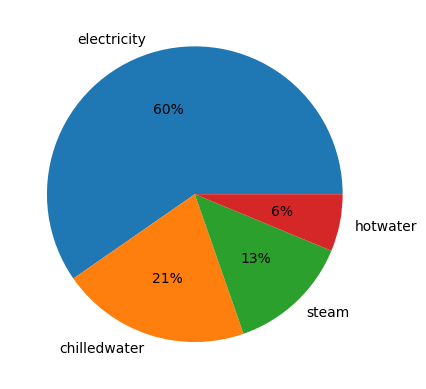

In [14]:


# Create the pie chart
fig = plt.pie(df['meter'].value_counts().values, 
             labels=df['meter'].value_counts().index,autopct='%.0f%%',
             )

plt.show()


**BUILDING AGE AND ENERGY CONSUMPTION**

In [17]:
import datetime
import pandas as pd
import plotly.express as px

# Calculate the current year
current_year = datetime.datetime.now().year

# Calculate the building age by subtracting the year of construction from the current year
df['building_age'] = current_year - pd.to_datetime(df['year_built']).dt.year

# Filter the DataFrame to include only necessary columns and drop missing values
df_subset = df[['building_age', 'meter_reading', 'meter', 'building_id']].dropna()

# # Sample a smaller subset of the data (e.g., 10% of the original data)
# df_subset_sample = df_subset.sample(frac=0.1, random_state=1)

# Create the scatter plot with meter-based colors
fig = px.scatter(df_subset, x='building_age', y='meter_reading', color='meter', hover_data=['building_id'])

# Update axis labels and title
fig.update_layout(
    xaxis=dict(title='Building Age'),
    yaxis=dict(title='Energy Consumption (kWh)'),
    title='Relationship between Building Age and Energy Consumption'
)

# Show the figure
fig.show()


In [1]:
df_subset.info()

NameError: name 'df_subset' is not defined

IT CAN BE CLEARLY OBSERVED THAT THERE IS AN OUTLIER HERE WHICH IS BUILDING_ID 26 and the maximum energy it has consumed is 50,000 kWh

In [17]:
df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  7, 15], dtype=int8)

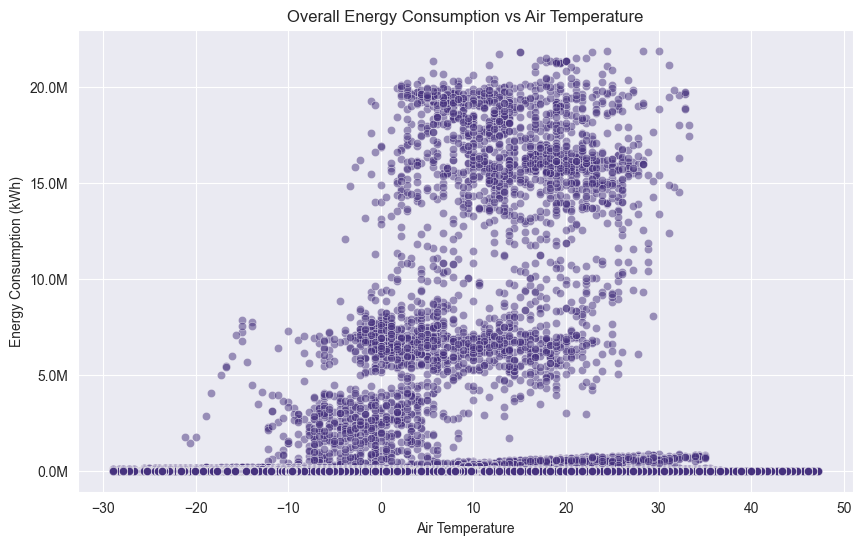

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Filter the DataFrame to include only the necessary columns
df_subset = df[['air_temperature', 'meter_reading']]

# Set up a beautiful and futuristic style
sns.set_style('darkgrid')
sns.set_palette('viridis')

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_subset, x='air_temperature', y='meter_reading', alpha=0.5, ax=ax)
ax.set_xlabel('Air Temperature')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Overall Energy Consumption vs Air Temperature')

# Format y-axis labels in millions (M)
formatter = mticker.FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Add additional customizations if desired
# ...

plt.show()


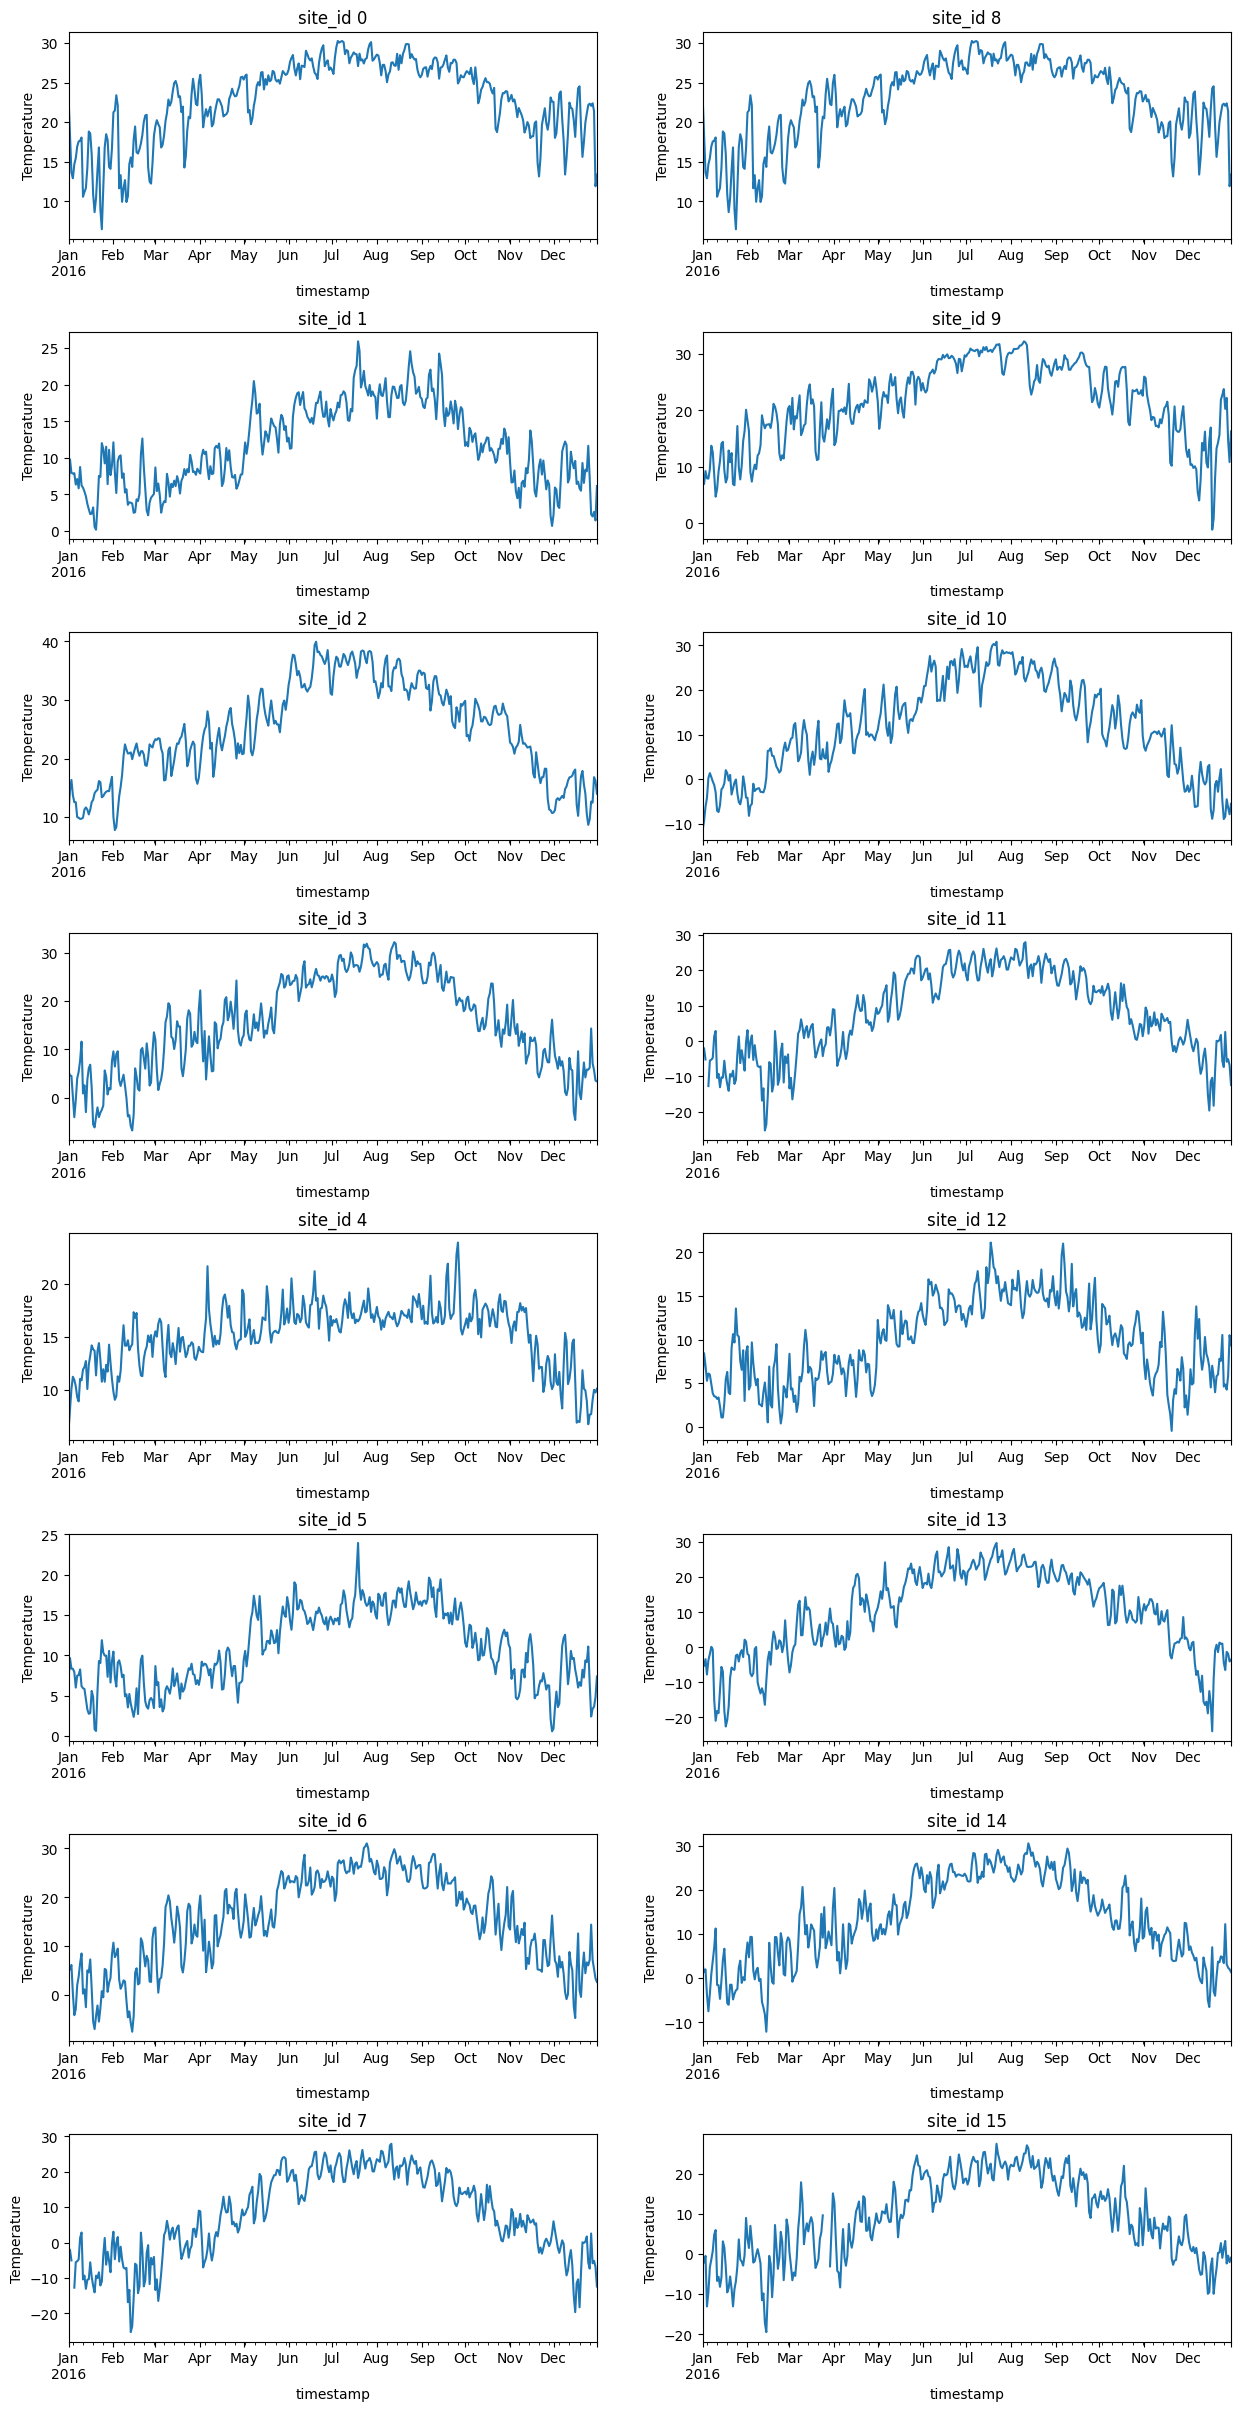

In [24]:
fig,ax=plt.subplots(8,2,figsize=(15,30))
for i in range(16):
    df[df['site_id']==i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=ax[i%8][i//8]).set_ylabel('Temperature')
    ax[i%8][i//8].set_title('site_id {}'.format(i))
    plt.subplots_adjust(hspace=0.45)

**ENERGY DISTRIBUTION FOR 7 DAYS IN A WEEK FOR DIFFERENT SITE_ID**

In [22]:
# import plotly.subplots as sp
# import plotly.graph_objects as go

# # Filter the DataFrame to include only necessary columns
# df_subset = df[['site_id', 'timestamp', 'meter_reading']]

# Create subplots with a grid layout of 8 rows and 2 columns
fig = sp.make_subplots(rows=8, cols=2, subplot_titles=[f"Site {site_id}" for site_id in range(16)])

# Define the desired order of days
desired_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Iterate over each site_id and create a line chart in the corresponding subplot
for i, site_id in enumerate(range(16)):
    # Filter data for the current site_id
    site_data = df_subset[df_subset['site_id'] == site_id]
    
    # Convert the timestamp to day of the week
    site_data['day_of_week'] = site_data['timestamp'].dt.strftime('%A')
    
    # Group the data by day of the week and calculate the sum of meter_reading for each day
    daily_data = site_data.groupby('day_of_week')['meter_reading'].sum()
    
    # Reorder the daily_data based on the desired order
    daily_data = daily_data.reindex(desired_order)
    
    # Create the line chart trace
    trace = go.Scatter(x=daily_data.index, y=daily_data, mode='lines', name='Energy Consumption')
    
    # Add the trace to the corresponding subplot
    fig.add_trace(trace, row=(i // 2) + 1, col=(i % 2) + 1)

# Update layout settings
fig.update_layout(height=1200, width=1000, showlegend=False)

# Show the figure
fig.show()


C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_33716\1003920155.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_33716\1003920155.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_33716\1003920155.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [23]:
del df_subset

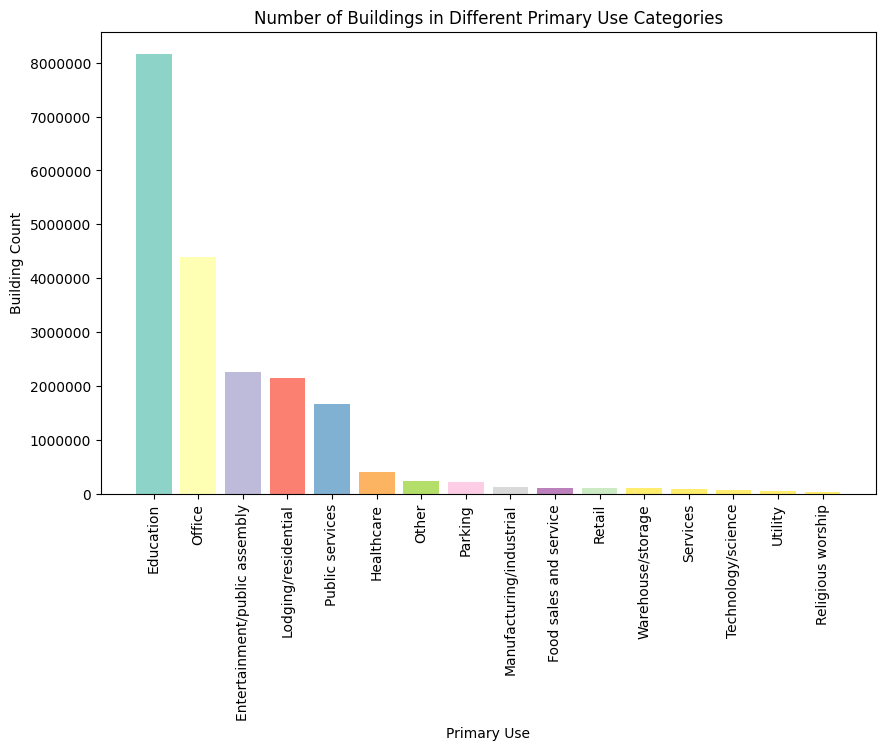

In [19]:
# Filter the DataFrame to include only the necessary columns
df_subset = df[['building_id', 'primary_use']]

# Count the number of buildings in each primary use category
building_counts = df_subset['primary_use'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(range(len(building_counts)))  # Generate colors for bars
plt.bar(building_counts.index, building_counts.values, color=colors)
plt.xlabel('Primary Use')
plt.ylabel('Building Count')
plt.title('Number of Buildings in Different Primary Use Categories')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')  # Display y-axis tick labels as plain numbers
plt.show()